# Importing Libraries

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc

## Data loading

In [25]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')
submission_df = pd.read_csv('sample_submission.csv')

display(train_df.head())
train_df.info()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## Data exploration


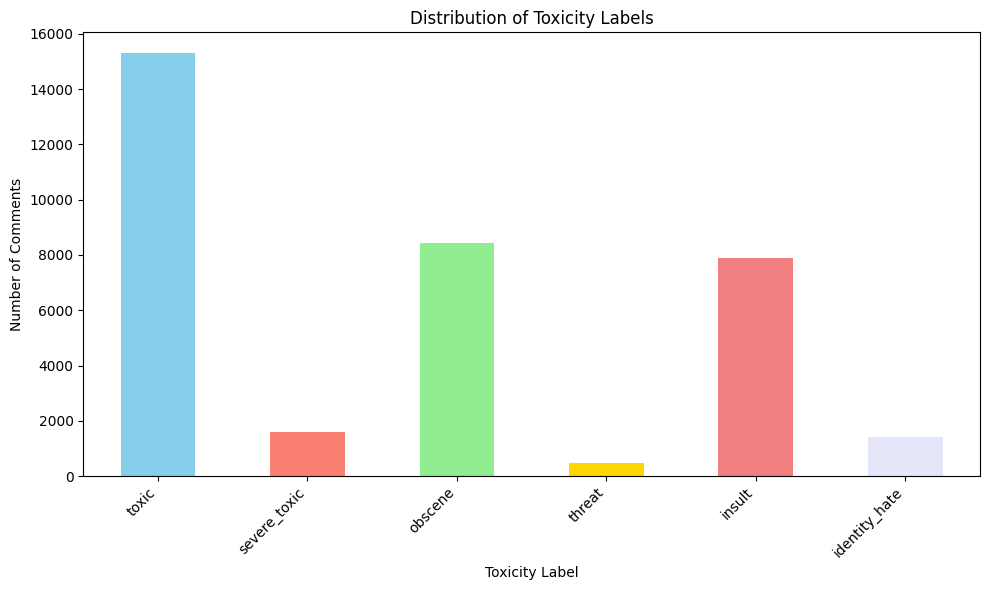

In [26]:
toxicity_counts = train_df.iloc[:, 2:].sum()
plt.figure(figsize=(10, 6))
toxicity_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lavender'])
plt.xlabel("Toxicity Label")
plt.ylabel("Number of Comments")
plt.title("Distribution of Toxicity Labels")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data preparation



In [27]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

train_df['comment_text'] = train_df['comment_text'].apply(preprocess_text)
test_df['comment_text'] = test_df['comment_text'].apply(preprocess_text)

target_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

## Data splitting



In [28]:
target_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
X = train_df['comment_text']
y = train_df[target_labels]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature engineering



In [29]:
vectorizer = TfidfVectorizer(max_features=20000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(test_df['comment_text'])

## Model training


In [30]:
def train_model(model, X_train_tfidf, y_train, X_val_tfidf, y_val):
    plt.figure(figsize=(8, 6))  # Initialize a single plot for all ROC curves
    roc_auc_scores = []

    for label in y_train.columns:
        model.fit(X_train_tfidf, y_train[label])
        y_pred = model.predict(X_val_tfidf)
        y_pred_prob = model.decision_function(X_val_tfidf) if hasattr(model, "decision_function") else model.predict_proba(X_val_tfidf)[:, 1]
        roc_auc = roc_auc_score(y_val[label], y_pred_prob)
        roc_auc_scores.append(roc_auc)

        print(f"ROC AUC Score for {label}: {roc_auc}")
        print(f"Classification Report for {label}:\n{classification_report(y_val[label], y_pred)}")

        # Confusion Matrix
        cm = confusion_matrix(y_val[label], y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix for {label}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # ROC Curve for all labels in one plot
        fpr, tpr, _ = roc_curve(y_val[label], y_pred_prob)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

    # Plot diagonal line for reference
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for All Toxicity Labels')
    plt.legend()
    plt.show()

    # Calculate and print the average ROC AUC score across all labels
    avg_roc_auc = np.mean(roc_auc_scores)
    print(f"Average ROC AUC Score: {avg_roc_auc}")

# Instantiate the models
logreg_model = LogisticRegression(class_weight='balanced', max_iter=1000)
svm_model = LinearSVC(class_weight='balanced')

Logistic Regression:
ROC AUC Score for toxic: 0.9679681021318856
Classification Report for toxic:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     28859
           1       0.63      0.85      0.72      3056

    accuracy                           0.94     31915
   macro avg       0.81      0.90      0.84     31915
weighted avg       0.95      0.94      0.94     31915



<Figure size 800x600 with 0 Axes>

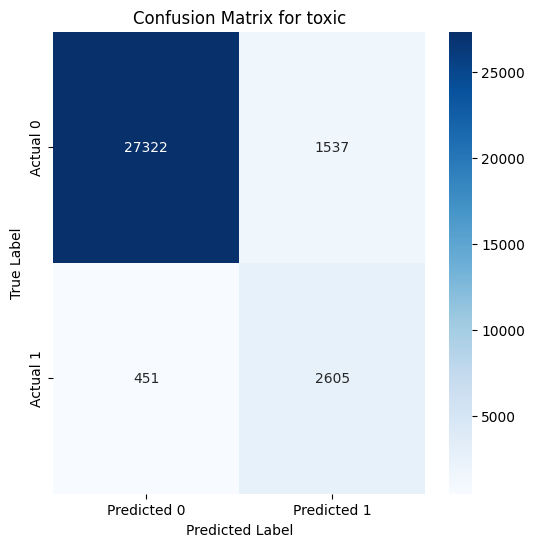

ROC AUC Score for severe_toxic: 0.9807076721259231
Classification Report for severe_toxic:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31594
           1       0.26      0.85      0.40       321

    accuracy                           0.97     31915
   macro avg       0.63      0.91      0.69     31915
weighted avg       0.99      0.97      0.98     31915



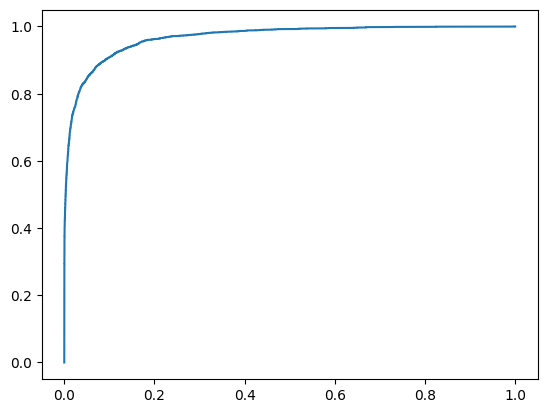

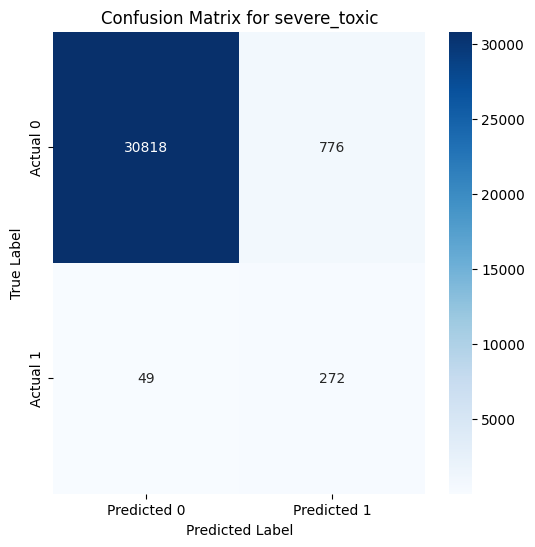

ROC AUC Score for obscene: 0.9829266889347981
Classification Report for obscene:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     30200
           1       0.66      0.88      0.76      1715

    accuracy                           0.97     31915
   macro avg       0.83      0.93      0.87     31915
weighted avg       0.98      0.97      0.97     31915



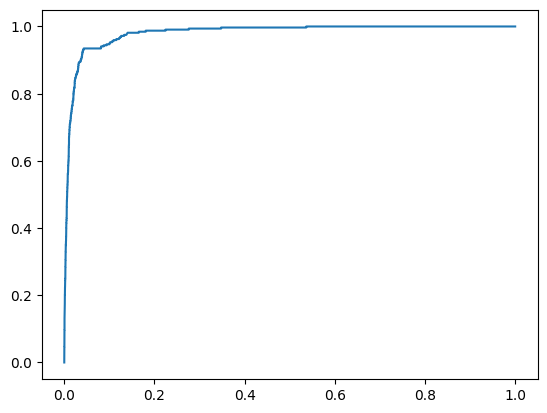

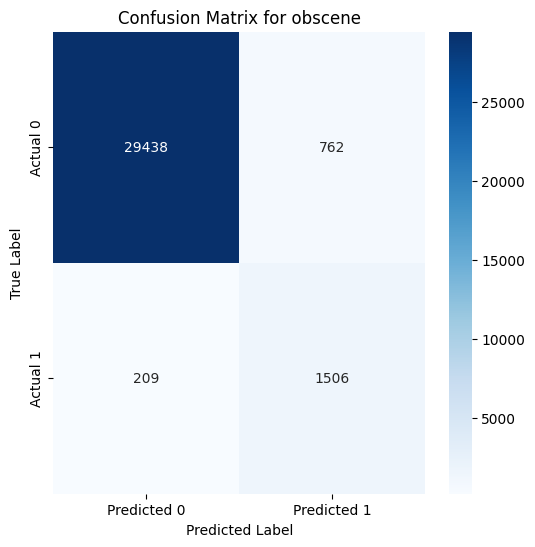

ROC AUC Score for threat: 0.987880448206757
Classification Report for threat:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     31841
           1       0.16      0.70      0.26        74

    accuracy                           0.99     31915
   macro avg       0.58      0.85      0.63     31915
weighted avg       1.00      0.99      0.99     31915



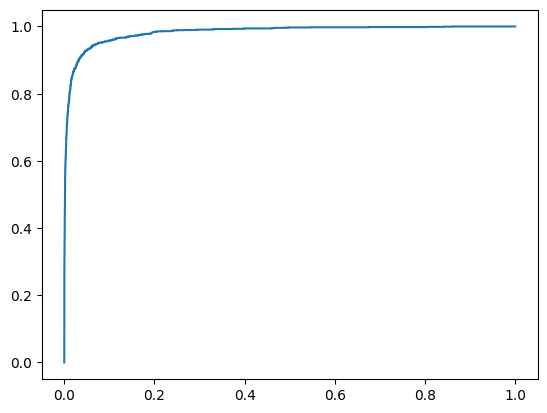

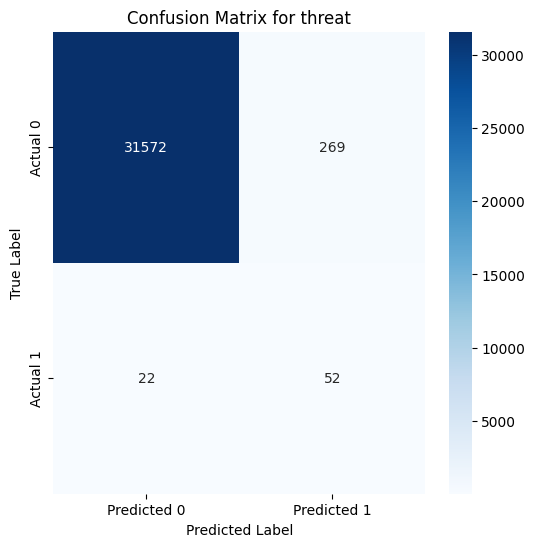

ROC AUC Score for insult: 0.9750693342922377
Classification Report for insult:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     30301
           1       0.53      0.86      0.66      1614

    accuracy                           0.95     31915
   macro avg       0.76      0.91      0.82     31915
weighted avg       0.97      0.95      0.96     31915



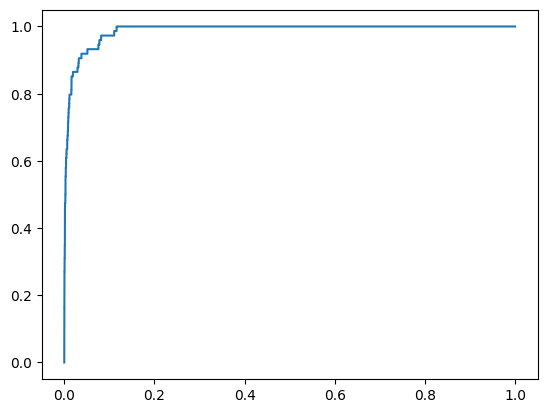

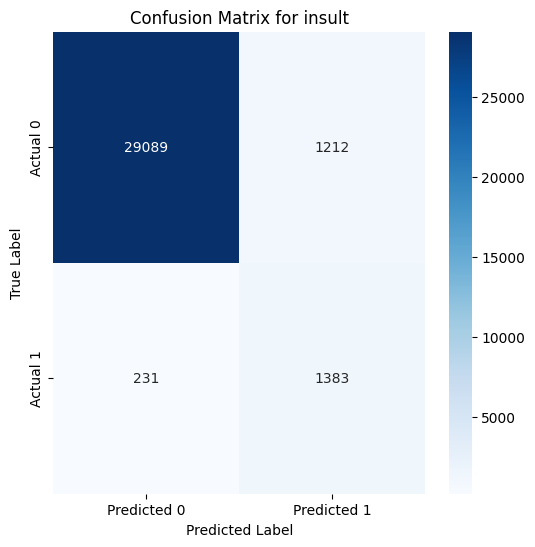

ROC AUC Score for identity_hate: 0.9647463140722594
Classification Report for identity_hate:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     31621
           1       0.22      0.78      0.34       294

    accuracy                           0.97     31915
   macro avg       0.61      0.87      0.66     31915
weighted avg       0.99      0.97      0.98     31915



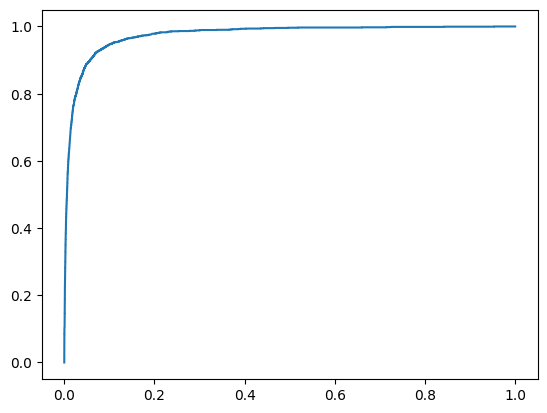

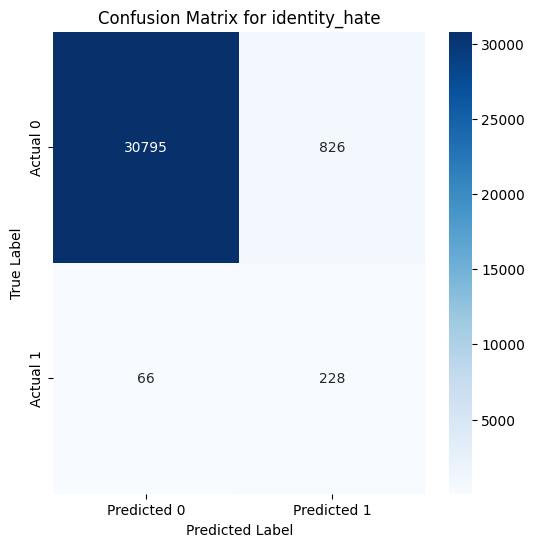

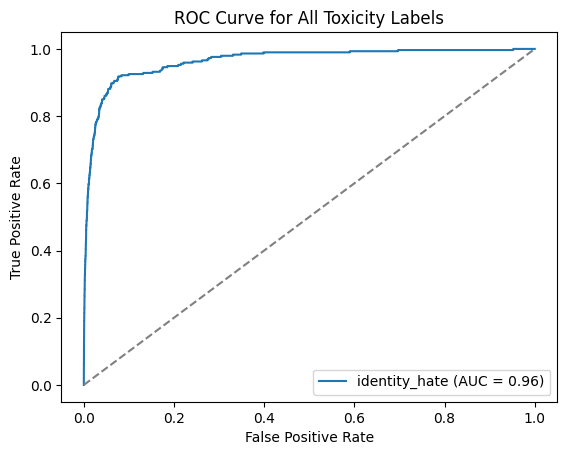

Average ROC AUC Score: 0.9765497599606435


In [31]:
# Train and evaluate the models
print("Logistic Regression:")
train_model(logreg_model, X_train_tfidf, y_train, X_val_tfidf, y_val)


Support Vector Machine:
ROC AUC Score for toxic: 0.9588894331239324
Classification Report for toxic:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     28859
           1       0.63      0.83      0.71      3056

    accuracy                           0.94     31915
   macro avg       0.80      0.89      0.84     31915
weighted avg       0.95      0.94      0.94     31915



<Figure size 800x600 with 0 Axes>

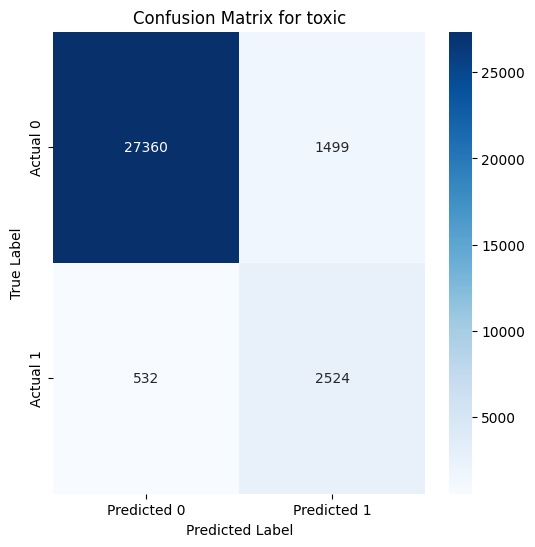

ROC AUC Score for severe_toxic: 0.963575687800653
Classification Report for severe_toxic:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31594
           1       0.27      0.72      0.39       321

    accuracy                           0.98     31915
   macro avg       0.63      0.85      0.69     31915
weighted avg       0.99      0.98      0.98     31915



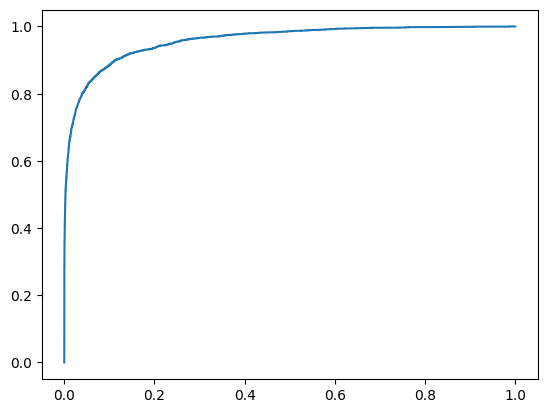

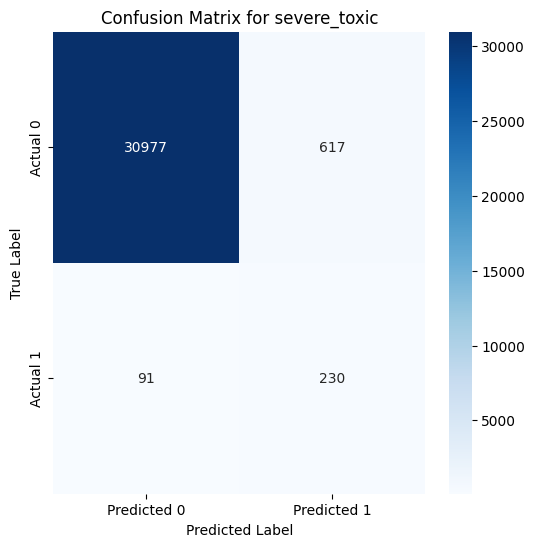

ROC AUC Score for obscene: 0.9741082964879424
Classification Report for obscene:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     30200
           1       0.67      0.84      0.75      1715

    accuracy                           0.97     31915
   macro avg       0.83      0.91      0.86     31915
weighted avg       0.97      0.97      0.97     31915



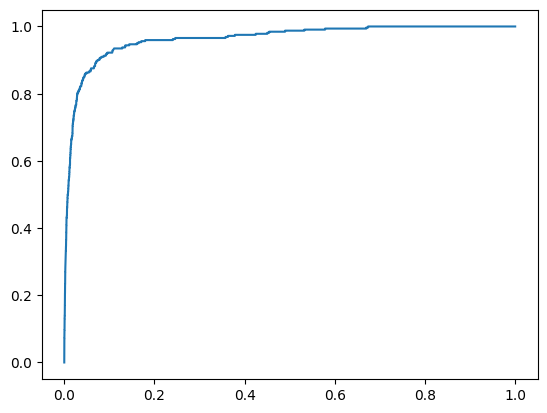

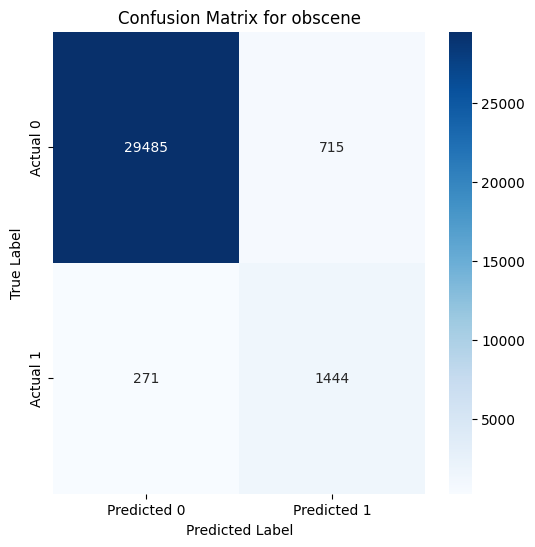

ROC AUC Score for threat: 0.9686141104830845
Classification Report for threat:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31841
           1       0.25      0.51      0.33        74

    accuracy                           1.00     31915
   macro avg       0.62      0.75      0.67     31915
weighted avg       1.00      1.00      1.00     31915



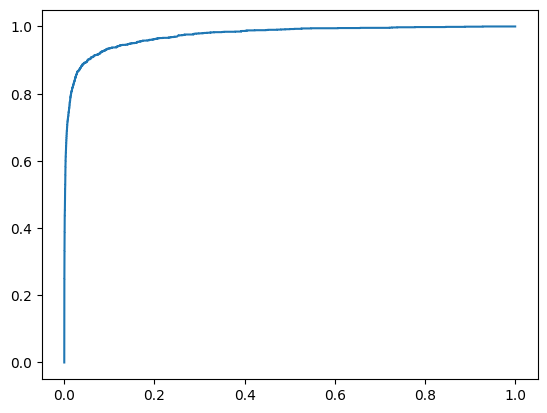

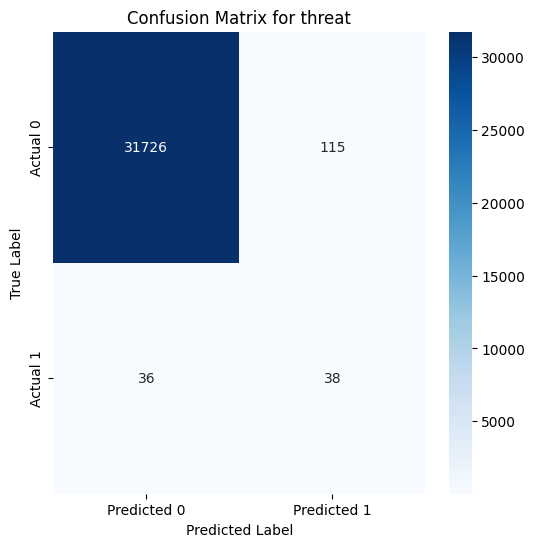

ROC AUC Score for insult: 0.9604165774645933
Classification Report for insult:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     30301
           1       0.53      0.80      0.64      1614

    accuracy                           0.95     31915
   macro avg       0.76      0.88      0.81     31915
weighted avg       0.97      0.95      0.96     31915



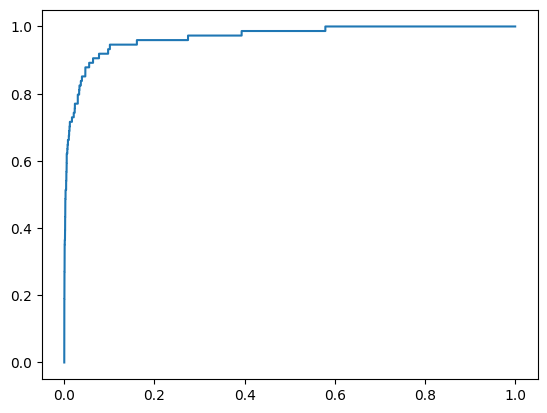

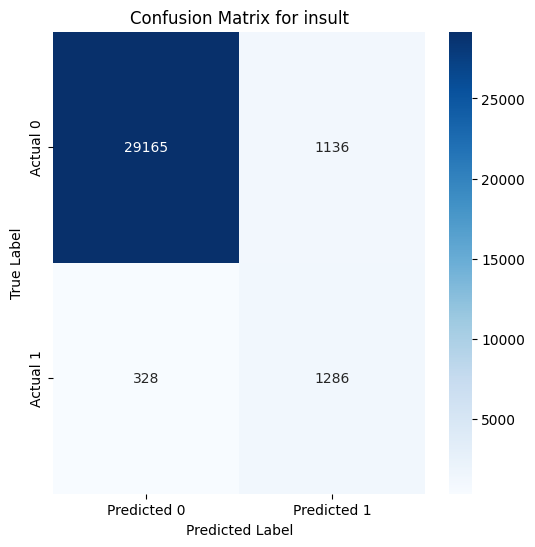

ROC AUC Score for identity_hate: 0.9414408469184453
Classification Report for identity_hate:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31621
           1       0.25      0.59      0.35       294

    accuracy                           0.98     31915
   macro avg       0.62      0.78      0.67     31915
weighted avg       0.99      0.98      0.98     31915



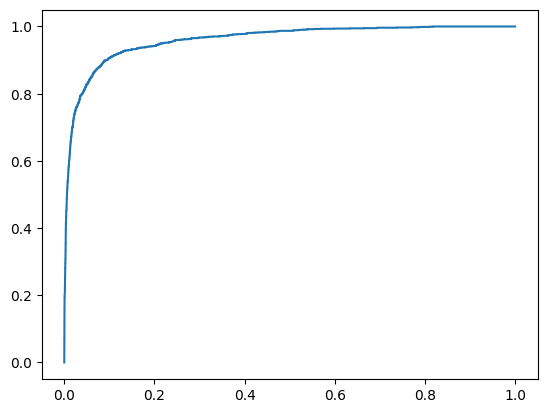

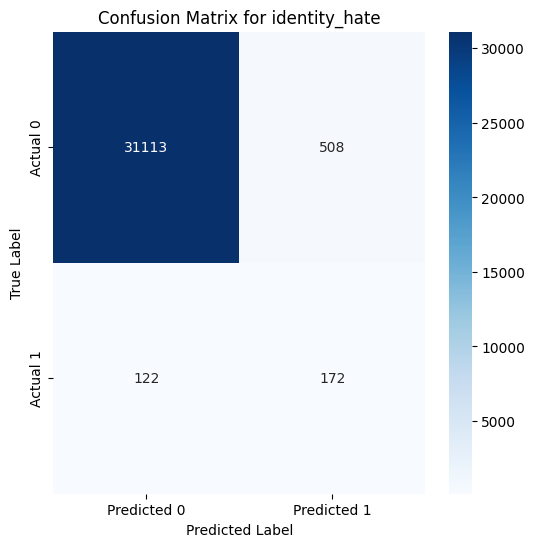

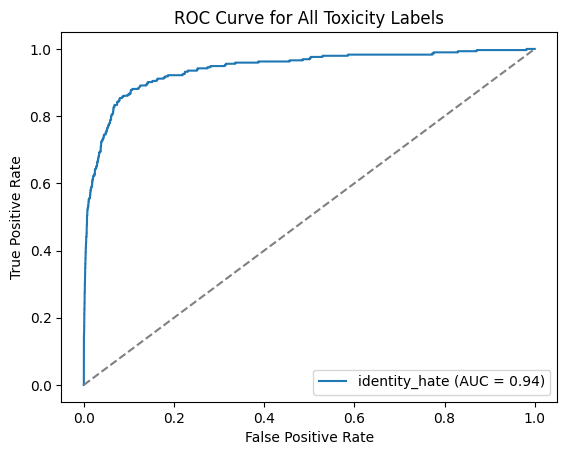

Average ROC AUC Score: 0.9611741587131085


In [32]:
print("\nSupport Vector Machine:")
train_model(svm_model, X_train_tfidf, y_train, X_val_tfidf, y_val)

## Model evaluation



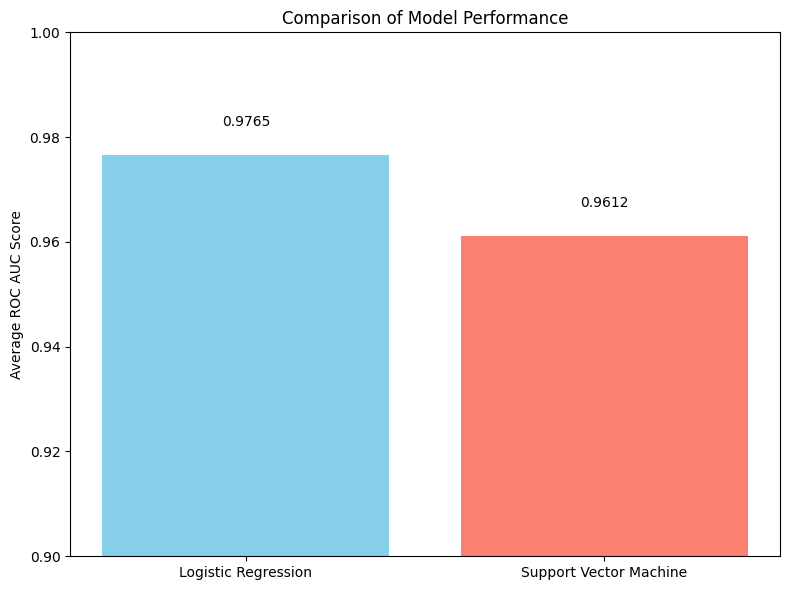

In [37]:
# Replace these with the actual values from the previous output.
logreg_avg_roc_auc = 0.9765497599606435
svm_avg_roc_auc = 0.9611741587131085

avg_roc_auc_scores = {
    "Logistic Regression": logreg_avg_roc_auc,
    "Support Vector Machine": svm_avg_roc_auc,
}

# Extract model names and scores for plotting
model_names = list(avg_roc_auc_scores.keys())
scores = list(avg_roc_auc_scores.values())

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(model_names, scores, color=['skyblue', 'salmon'])
plt.ylabel("Average ROC AUC Score")
plt.title("Comparison of Model Performance")
plt.ylim([0.9, 1.0])  # Adjust y-axis limits for better visualization

# Add data labels above the bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.005, f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Model training



In [34]:
# Train the best model (Logistic Regression) on the entire training dataset
best_model = LogisticRegression(max_iter=1000)
for label in target_labels:
    best_model.fit(X_train_tfidf, y_train[label])

## Best Model evaluation




In [35]:
# Predict probabilities for each toxicity label in the test dataset
predicted_probabilities = pd.DataFrame(best_model.predict_proba(X_test_tfidf)[:, 1], columns=['toxic'])

for label in target_labels[1:]:
    best_model.fit(X_train_tfidf, y_train[label])
    predicted_probabilities[label] = best_model.predict_proba(X_test_tfidf)[:, 1]

# Ensure the index matches the submission DataFrame's 'id' column
predicted_probabilities.index = submission_df['id']

predicted_probabilities = predicted_probabilities.clip(0, 1)

display(predicted_probabilities.head())

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.106912,0.058605,0.961494,0.016929,0.762006,0.106912
0000247867823ef7,0.003706,0.003195,0.006217,0.001848,0.007627,0.003706
00013b17ad220c46,0.001823,0.001492,0.005229,0.000830,0.006464,0.001823
00017563c3f7919a,0.001012,0.001733,0.003063,0.001011,0.002872,0.001012
00017695ad8997eb,0.002894,0.002025,0.011482,0.001673,0.015161,0.002894


## Data preparation



In [36]:
# Reset the index of predicted_probabilities first
predicted_probabilities = predicted_probabilities.reset_index()

# Ensure the index of predicted_probabilities aligns with submission_df
predicted_probabilities = predicted_probabilities.set_index('id')
submission_df = submission_df.set_index('id')

# Update the toxicity label columns in submission_df
submission_df[predicted_probabilities.columns] = predicted_probabilities

display(submission_df.head())

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.106912,0.058605,0.961494,0.016929,0.762006,0.106912
0000247867823ef7,0.003706,0.003195,0.006217,0.001848,0.007627,0.003706
00013b17ad220c46,0.001823,0.001492,0.005229,0.000830,0.006464,0.001823
00017563c3f7919a,0.001012,0.001733,0.003063,0.001011,0.002872,0.001012
00017695ad8997eb,0.002894,0.002025,0.011482,0.001673,0.015161,0.002894
